# Nonparametric Discovery of Human Routines from Sensor Data
This notebook tried to reproduce the result from the paper:
Nonparametric Discovery of Human Routines from Sensor Data
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.681.3152&rep=rep1&type=pdf


In [1883]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

from sklearn.mixture import BayesianGaussianMixture
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import AffinityPropagation
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans

import scipy as sp
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.stats import invwishart
from scipy.special import gammaln
from scipy.spatial.distance import jensenshannon

from numpy.random import choice
from numpy.linalg import inv


from collections import OrderedDict
from random import choices

from gensim.sklearn_api import HdpTransformer

from itertools import chain
from statistics import mode
import itertools

import pickle

In [3]:
path = 'dataset_huynh_ubicomp08'
full = np.zeros(shape=(1,1))
for i in range(7):
    data = np.loadtxt(path+'/day'+str(i+1)+'-data.txt')
    activities = np.expand_dims( np.loadtxt(path+'/day'+str(i+1)+'-activities.txt') , axis=1)
    routines = np.expand_dims( np.loadtxt(path+'/day'+str(i+1)+'-routines.txt') , axis=1)
    data =  np.concatenate((data, activities, routines), axis=1)
    if i==0:
        total = data
    total = np.concatenate((total,data), axis=0 )

In [1301]:
features = ['mean_px','mean_py','mean_pz','var_px','var_py','var_pz','mean_wx','mean_wy','mean_wz','var_wx','var_wy','var_wz','time','activities','routines']
total = pd.DataFrame(data=total,columns=features)
total['activities'] = total['activities'].astype(int)
total['routines'] = total['routines'].astype(int)
routines_label = [ 'unlabeled', 'dinner activities', 'commuting', 'lunch routine', 'office work']

In [963]:
activities_label = {}
with open(path+'/activities.txt') as fp:
    line = fp.readline()
    cnt = 0
    while line:
        print("Line {}: {}".format(cnt, line.strip()))
        if (line.strip() != ''):
            activities_label[cnt] = line.strip()
        line = fp.readline()
        cnt += 1

Line 0: unlabeled
Line 1: driving bike
Line 2: driving cart through supermarket
Line 3: driving car
Line 4: brushing teeth
Line 5: personal hygiene
Line 6: kneeling
Line 7: running
Line 8: sitting  having a coffee
Line 9: having breakfast
Line 10: having dinner
Line 11: having lunch
Line 12: sitting  talking on phone
Line 13: using the toilet
Line 14: sitting  desk activities
Line 15: standing  talking
Line 16: standing  having a coffee
Line 17: queuing in line
Line 18: standing  talking on phone
Line 19: standing  using the toilet
Line 20: walking
Line 21: walking while carrying something
Line 22: walking freely
Line 23: washing dishes
Line 24: picking up mensa food
Line 25: lying  using computer
Line 26: wiping the whiteboard
Line 27: discussing at whiteboard
Line 28: kneeling  making fire for barbecue
Line 29: fanning barbecue
Line 30: washing hands
Line 31: setting the table
Line 32: watching movie
Line 33: making coffee
Line 34: attending a presentation
Line 35: preparing food
Lin

Text(0.5, 1.0, 'dinner activities')

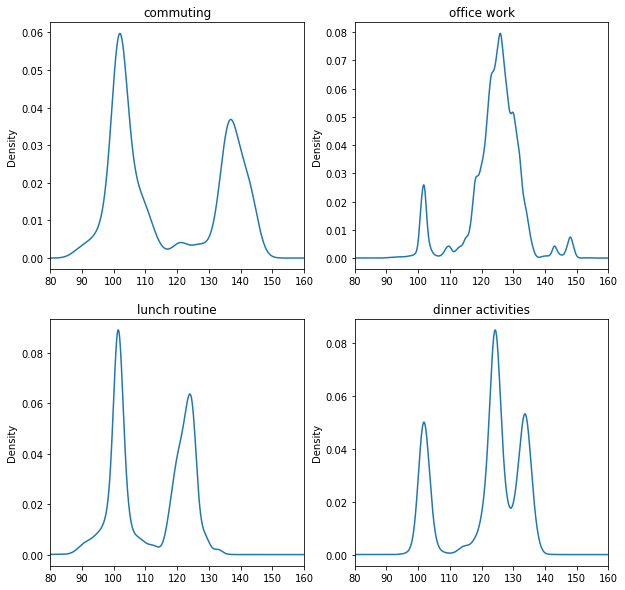

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(10,10) )
axs[0,0].set_xlim([80, 160])
#axs[0,0].legend('test', loc='upper right')
total[total.routines ==2]['mean_py'].plot(kind='kde', ax=axs[0, 0])
axs[0,0].set_title('commuting')

axs[0,1].set_xlim([80, 160])
total[total.routines ==4]['mean_py'].plot(kind='kde', ax=axs[0, 1])
axs[0,1].set_title( 'office work' )

axs[1,0].set_xlim([80, 160])
total[total.routines ==3]['mean_py'].plot(kind='kde', ax=axs[1, 0])
axs[1,0].set_title('lunch routine')

axs[1,1].set_xlim([80, 160])
total[total.routines ==1]['mean_py'].plot(kind='kde', ax=axs[1, 1])
axs[1,1].set_title('dinner activities')

Text(0.5, 1.0, 'dinner activities')

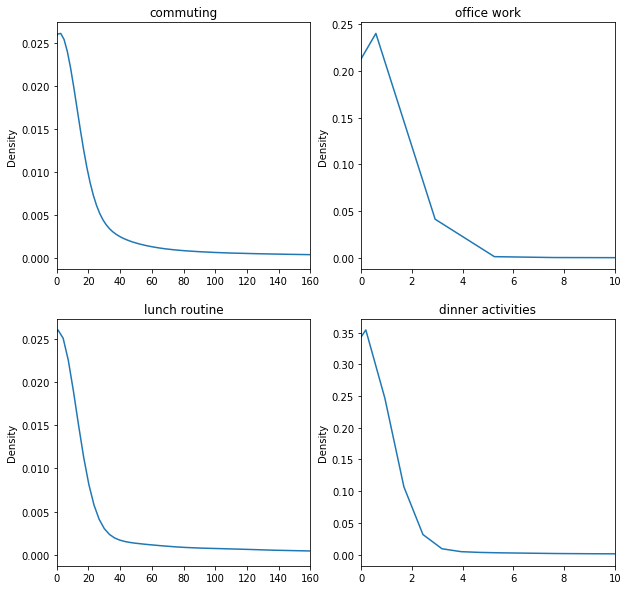

In [846]:
fig, axs = plt.subplots(2, 2, figsize=(10,10) )
axs[0,0].set_xlim([0, 160])
#axs[0,0].legend('test', loc='upper right')
total[total.routines ==2]['var_py'].plot(kind='kde', ax=axs[0, 0])
axs[0,0].set_title('commuting')

axs[0,1].set_xlim([0, 10])
total[total.routines ==4]['var_py'].plot(kind='kde', ax=axs[0, 1])
axs[0,1].set_title( 'office work' )

axs[1,0].set_xlim([0, 160])
total[total.routines ==3]['var_py'].plot(kind='kde', ax=axs[1, 0])
axs[1,0].set_title('lunch routine')

axs[1,1].set_xlim([0, 10])
total[total.routines ==1]['var_py'].plot(kind='kde', ax=axs[1, 1])
axs[1,1].set_title('dinner activities')

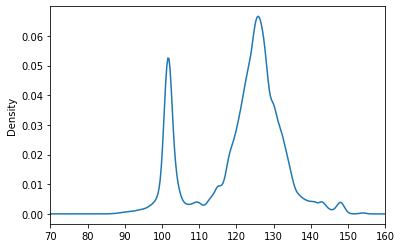

In [850]:
fig, ax = plt.subplots()
ax.set_xlim([70, 160])
total['mean_py'].plot(kind='kde', ax=ax)

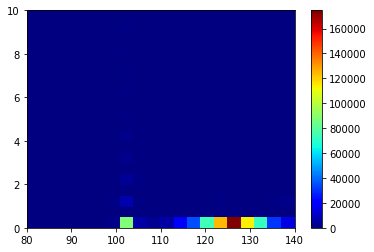

In [845]:
plt.hist2d(total['mean_py'], total['var_py'], range=[[80,140],[0,10]], bins=(20, 20), cmap=plt.cm.jet)
plt.colorbar()

# Dirichlet process Gaussian mixture model (DPGMM)
Library:  
sklearn.mixture.BayesianGaussianMixture

In [6]:
subspaces = [ ['mean_px','var_px'], ['mean_py','var_py'], ['mean_pz','var_pz'], ['mean_wx','var_wx'], ['mean_wy','var_wy'], ['mean_wz','var_wz'] ]

In [851]:
total[  list( chain.from_iterable(subspaces) ) ].describe()

,mean_px,var_px,mean_py,var_py,mean_pz,var_pz,mean_wx,var_wx,mean_wy,var_wy,mean_wz,var_wz
count,887661.000000,887661.000000,887661.000000,887661.000000,887661.000000,887661.000000,887661.000000,887661.000000,887661.000000,887661.000000,887661.000000,887661.000000
mean,143.706008,8.311775,121.358922,7.140563,107.682089,4.276267,120.292426,5.142271,113.347698,4.676724,98.261666,2.872498
std,10.679764,57.735157,11.550218,44.619971,8.763871,28.769430,10.853985,28.856353,7.726753,27.972884,8.906067,18.491441
min,7.000000,-0.389291,7.000000,-0.476128,7.000000,-1.813154,62.558221,-94.534730,82.062948,-88.604889,65.803783,-81.249267
25%,138.000000,0.000000,117.000000,0.000000,100.000000,0.000000,117.000000,0.000000,108.951820,0.000000,91.648596,0.000000
50%,148.000000,0.000000,124.000000,0.000000,108.000000,0.000000,121.009382,0.000000,113.972670,0.000000,95.000000,0.000000
75%,151.000000,0.000000,128.000000,0.000000,114.000000,0.000000,123.442031,0.227137,118.059578,1.118410,103.000000,0.595182
max,163.000000,1422.000000,155.000000,1621.000000,139.000000,1253.000000,155.061983,1644.596781,178.445634,1568.648643,143.629420,1593.851007


In [1302]:
############## testing fewer cluster

In [1312]:
model_bay = [ None for _ in range(len(subspaces)) ]
score_bay = [ None for _ in range(len(subspaces)) ]
converge_bay = [None for _ in range(len(subspaces)) ]

In [1657]:
parameters = [(8,10,2)]
for i_subspace, sub in enumerate(subspaces):
    print("subspace:", i_subspace )
    for i,para in enumerate( parameters ):
        n_com, weight, dof = para
        print( n_com, weight, dof )
        model_bay[i_subspace]= BayesianGaussianMixture( n_components=n_com, covariance_type= 'full',max_iter=2000, init_params= 'kmeans', weight_concentration_prior_type = 'dirichlet_process',
                                                   weight_concentration_prior= weight, degrees_of_freedom_prior=dof, warm_start= True, verbose=1) 
        model_bay[i_subspace].fit(  total[subspaces[i_subspace]]  )
        score_bay[i_subspace] = model_bay[ i_subspace  ].score(  total[subspaces[i_subspace]]  ) 
        converge_bay[i_subspace] = model_bay[ i_subspace  ].converged_
        print(  converge_bay[i_subspace] )
        print(  score_bay[i_subspace] )

subspace: 0
8 10 2
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
  Iteration 100
  Iteration 110
  Iteration 120
  Iteration 130
  Iteration 140
  Iteration 150
  Iteration 160
  Iteration 170
  Iteration 180
  Iteration 190
  Iteration 200
  Iteration 210
  Iteration 220
  Iteration 230
  Iteration 240
  Iteration 250
  Iteration 260
  Iteration 270
  Iteration 280
  Iteration 290
  Iteration 300
  Iteration 310
  Iteration 320
  Iteration 330
  Iteration 340
  Iteration 350
  Iteration 360
  Iteration 370
  Iteration 380
  Iteration 390
  Iteration 400
  Iteration 410
  Iteration 420
  Iteration 430
  Iteration 440
  Iteration 450
  Iteration 460
  Iteration 470
Initialization converged: True
True
-2.90996909976714
subspace: 1
8 10 2
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration

In [1309]:
label_test =None
for index_sub, sub in enumerate(subspaces[0:1]):
    label_test = model_bay[0].predict(total[sub])

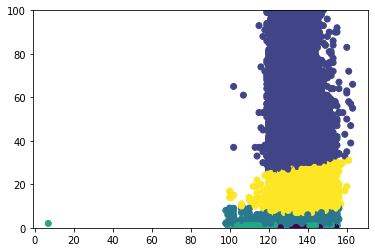

In [1836]:
plt.scatter(total[subspaces[0][0]], total[subspaces[0][1]], c=label_test )
plt.ylim(0, 100)
plt.show()

In [ ]:
#####################

In [ ]:
###
dirichlet =  model_bay

In [1658]:
# Save the model
pickle.dump(dirichlet, open('pkl_objects/model_cluster8_alpha10.pkl','wb'))

In [1660]:
label = []
for index_sub, sub in enumerate(subspaces[:]):
    label.append( dirichlet[index_sub].predict(total[sub]) )

In [1661]:
# create the features for the artificial words
words_features = []
for i, sub in enumerate(subspaces[:]):
    total['w'+str(i+1)] = label[i]
    words_features.append('w'+str(i+1))

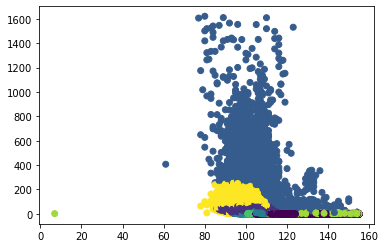

In [1662]:
plt.scatter(total[subspaces[1][0]], total[subspaces[1][1]], c=label[1] )
plt.show()

# Document creation  
Ref:  
T. Huynh, M. Fritz, and B. Schiele, “Discovery of activity patterns using topic models,” in Proceedings of the 10th international conference on Ubiquitous computing, New York, NY, USA, 2008, pp. 10–19.  
http://mobvis.org/publications/ubicomp2008.pdf

In [226]:
## Translate the Matlab serial date number to the day (with first day =0) and hour

In [1663]:
total['day'] =  (total['time']/(60*60*24)).astype(np.int32)
total['hour'] = ( total['time']/ (60*60*24) - total['day'] ) * 24

In [1664]:
day_min = total['day'].min()
day_max = total['day'].max()

In [1665]:
print(day_min,day_max)

13733 13741


In [1666]:
total['day'] = total['day'] - day_min
days = total['day'].value_counts().index.tolist()

In [1667]:
days

[8, 7, 6, 0, 5, 1, 2]

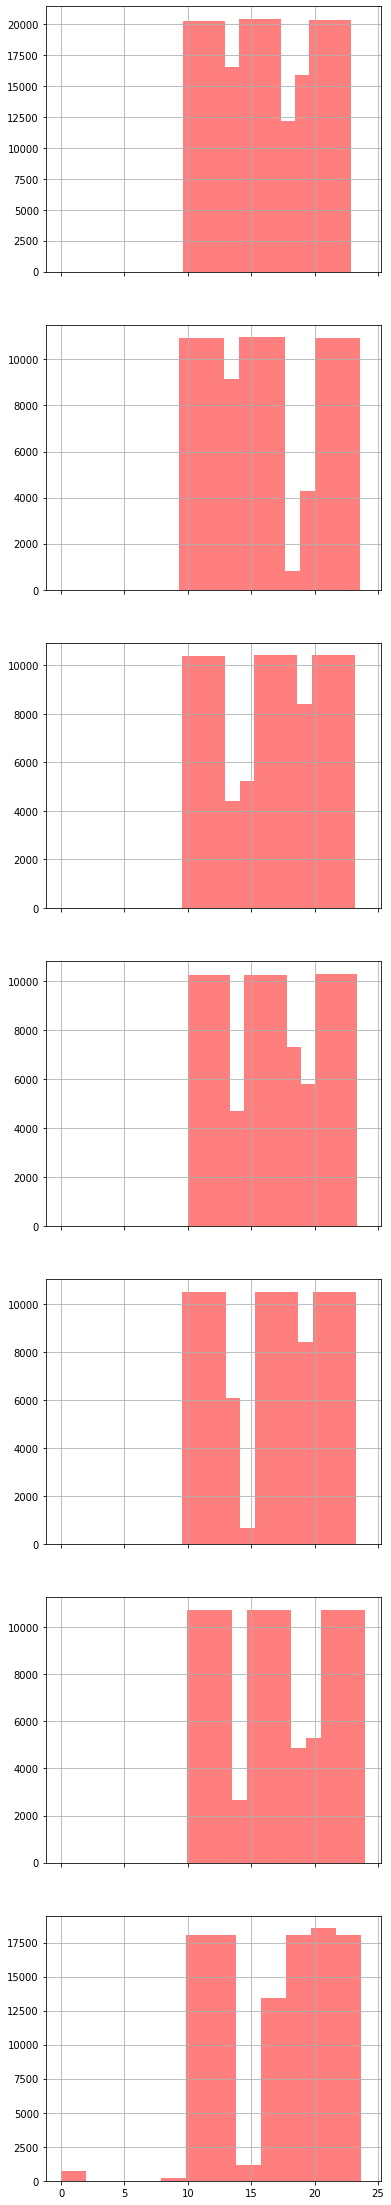

In [1668]:
# Check the histogram of the sensor data collection everyday
fig, ax = plt.subplots(7, 1, sharex='col', sharey='row', figsize=(6, 40))
n = 3
for i,day in enumerate(days):
    total[total.day==day]['hour'].hist(bins=12, ax=ax[i], alpha=0.5, color='red')
#    df.hist(column=df.columns[j+n], bins=12, ax=ax[j], alpha=0.5, color='blue')
#    ax[j].set_title(df.columns[j][2:])

### Create the label (the time in the unit of hour) for the documents

In [1669]:
time_interval = []
for day in days:
#    t0 = total[ total.day == day ].head(1)['time']
#    t1 = total[ total.day == day ].tail(1)['time']
#    n_interval = (t1 - t0)/ ( 27.5 * 60 )
    t0 = total[ (total.day == day) & (total.hour > 3) ]['hour'].min()  # The hour before 3 might be the data from previous day
    t1 = total[ total.day == day ]['hour'].max() 
    n_interval = int ( (t1 - t0) * 60 /  27.5 ) + 1
    interval = []
    for i in range(n_interval):
        interval.append( t0 + i * 27.5/60 )
    time_interval.append( interval )

In [1670]:
time_interval

[[9.578333331402973,
  10.036666664736307,
  10.49499999806964,
  10.953333331402973,
  11.411666664736307,
  11.86999999806964,
  12.328333331402973,
  12.786666664736307,
  13.24499999806964,
  13.703333331402973,
  14.161666664736305,
  14.619999998069641,
  15.078333331402973,
  15.536666664736305,
  15.994999998069641,
  16.453333331402973,
  16.911666664736305,
  17.36999999806964,
  17.828333331402973,
  18.28666666473631,
  18.744999998069638,
  19.203333331402973,
  19.66166666473631,
  20.119999998069638,
  20.578333331402973,
  21.03666666473631,
  21.494999998069638,
  21.953333331402973,
  22.41166666473631],
 [9.282222222493147,
  9.74055555582648,
  10.198888889159813,
  10.657222222493147,
  11.11555555582648,
  11.573888889159813,
  12.032222222493147,
  12.49055555582648,
  12.948888889159813,
  13.407222222493147,
  13.865555555826479,
  14.323888889159814,
  14.782222222493147,
  15.240555555826479,
  15.698888889159814,
  16.157222222493147,
  16.61555555582648,
  

## Create the documents

In [1671]:
# Then we will construct documents from sliding windows
# Bacause the sliding windows have overlap with 2.5 mins,
# each data points might belong to one or two sliding windows.
# The time of the data point t lies between [ tb_n , te_n ] => tb_n < t < te_n
# The overlap means sometimes tb_{n+1} < t < te_n 
# We can know whether the data point belongs to two sliding windows by:
# calculating the index (nb) of the beginning time of the sliding windows which is closest to the time of the data point
# and the index (ne) of the ending time of sliding windows which is closest to the time of the data point
documents_all = []
routines_all = []
activities_all = []

for i,day in enumerate(days):
    df = total[ (total.day == day) & (total.hour > 3) ] #
    t0 = df['time'].min()
    documents = [ [] for _ in range( len(time_interval[i]) )]
    routines = [ [] for _ in range( len(time_interval[i]) )]
    activities = [ [] for _ in range( len(time_interval[i]) )]
    for index, row in df.iterrows():
        word = row[ words_features ].astype(int).tolist()
        deltat = ( row['time'] - t0 )/60  # devided by 60 because we want to use the unit minute 
        nb = int( deltat /  27.5 )    # 0,1,2,.....
        ne = int( ( deltat - 30 ) / 27.5 ) + 1
        ne = ne if ne >= 0 else 0     # 0,1,2...
        documents[ne].append( word )
        routines[ne].append( row[ 'routines' ] )
        activities[ne].append( row[ 'activities' ] )
        if (nb == ne+1): 
            documents[nb].append( word )
            routines[nb].append( row[ 'routines' ] )
            activities[nb].append( row[ 'activities' ] )
    documents_all = documents_all + documents
    routines_all = routines_all + routines
    activities_all = activities_all + activities

In [1672]:
# TO make sure that there is no empty 
i_doc = -1
i_doc_empty = []
i_empty_time = []
for i in range(len(time_interval) ):
    for j in range( len(time_interval[i]) ):
        i_doc += 1
        if( documents_all[ i_doc ] == [] ):
            i_doc_empty.append( i_doc )
            i_empty_time.append( (i,j) )

for i in reversed(i_doc_empty):
    documents_all.pop(i)
    routines_all.pop(i)
    activities_all.pop(i)
for i,j in reversed(i_empty_time):
    time_interval[i].pop(j)

# hierarchical Dirichlet process  
Library:  
https://radimrehurek.com/gensim/sklearn_api/hdp.html  
Ref:  
T. Huynh, M. Fritz, and B. Schiele, “Discovery of activity patterns using topic models,” in Proceedings of the 10th international conference on Ubiquitous computing, New York, NY, USA, 2008, pp. 10–19.  
http://mobvis.org/publications/ubicomp2008.pdf

In [1785]:
count = CountVectorizer(max_features=1000)   
# Control max_features and min_df in order to get rid of low frequency words.

def list_to_bow( documents , count ):
    doc_list = []
    for doc in documents:
        string =''
        for a_word in doc:
            word = ''.join([chr( integer + 97 ) for integer in a_word])
            string = string + word + ' '
        doc_list.append( string )
    bag = count.fit_transform( doc_list )
    return bag, count

In [1786]:
bag, count = list_to_bow( documents_all , count )
id2token = {v: k for k, v in count.vocabulary_.items()}

In [1787]:
print(bag.shape)
print("len of the token dict :", len(id2token)) 

(199, 1000)
len of the token dict : 1000


In [1788]:
bag_list = [ [] for _ in range( bag.shape[0] )]
occurence = np.zeros( bag.shape[1] )
for i, j in zip(*bag.nonzero()):
    bag_list[i].append( (j, bag[i,j] ) )
    occurence[j] += bag[i,j]

In [1789]:
# check the cocurrence of the words
print( len(bag_list) )
print( np.sort(np.array(occurence))[:20] )

199
[42. 42. 42. 43. 43. 43. 43. 43. 43. 43. 43. 43. 43. 43. 43. 43. 43. 43.
 43. 43.]


In [1808]:
#model_hdp_list = []
##distr_ind = np.zeros( len(bag_list), 10 )
#n_hdp = 100
#distr_list = np.zeros( (n_hdp, len(bag_list), 10) )
#for i in range(n_hdp):
#    model_hdp_list.append( HdpTransformer(id2word=id2token,alpha=100, gamma=100, K=15, T=30, tau=64) )
#    model_hdp_list[-1].fit( bag )
#    distr0 = model_hdp_list[-1].transform( bag_list ) 
#    topic_top = (-np.sum(distr0, axis=0)).argsort()[:10]
#    for i_doc in range( distr0.shape[0] ):
#        for i_topic in range(10):
#            distr_list[i][i_doc][i_topic] = distr0[i_doc][ topic_top[i_topic] ]
#
#distr0 = np.mean(distr_list, axis=0)

In [1705]:
#model_hdp = HdpTransformer(id2word=id2token)
model_hdp = HdpTransformer(id2word=id2token,alpha=0.1, gamma=0.1, K=15, T=35, tau=64)
model_hdp.fit( bag )
#topic_distri = model_hdp.fit_transform(bag)

HdpTransformer(K=15, T=35, alpha=0.1, chunksize=256, eta=0.01, gamma=0.1,
               id2word={0: 'aaabfb', 1: 'aaaeba', 2: 'aaaebh', 3: 'aaahgc',
                        4: 'aacaac', 5: 'aacaag', 6: 'aacaah', 7: 'aacaba',
                        8: 'aacabc', 9: 'aacabh', 10: 'aacadc', 11: 'aacagc',
                        12: 'aacagh', 13: 'aacaha', 14: 'aacahc', 15: 'aacahf',
                        16: 'aacahg', 17: 'aacahh', 18: 'aacbaa', 19: 'aacbab',
                        20: 'aacbac', 21: 'aacbae', 22: 'aacbaf', 23: 'aacbag',
                        24: 'aacbah', 25: 'aacbba', 26: 'aacbbc', 27: 'aacbbf',
                        28: 'aacbbg', 29: 'aacbbh', ...},
               kappa=1.0, max_chunks=None, max_time=None, outputdir=None,
               random_state=None, scale=1.0, tau=64, var_converge=0.0001)

In [1706]:
distr = model_hdp.transform( bag_list )
distr.shape

(199, 35)

In [1694]:
distr

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.3407398 , 0.56044734, 0.03665112, ..., 0.        , 0.        ,
        0.        ],
       [0.30126214, 0.69873184, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.5153486 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.1793909 , 0.8205976 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.99984163, 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

# Affinity Propagation (AP) clustering with the usage of Jensen-Shannon divergence metric  
Library:  
scipy.spatial.distance.jensenshannon  + sklearn.cluster.AffinityPropagation  

Ref:  
B. J. Frey and D. Dueck, “Clustering by passing messages between data points,” Science, vol. 315, p. 2007, 2007. 
http://utstat.toronto.edu/reid/sta414/frey-affinity.pdf

### calculating the similarity between two topic proportions the usage of Jensen-Shannon divergence

In [1909]:
js_similarity = np.zeros(shape=(distr.shape[0],distr.shape[0]))
for j in range(distr.shape[0]):
    for i in range( j+1 ):
#         js_similarity[i][j] = math.exp( - (jensenshannon( distr[i], distr[j] ) )**2 ) 
        js_similarity[i][j] = math.exp( - (jensenshannon( distr[i], distr[j] ) ) ) 
#        js_similarity[i][j] = np.sum ( np.square( distr_act[i]- distr_act[j] ) )
        js_similarity[j][i] = js_similarity[i][j]

### Affinity Propagation (AP) clustering

In [1910]:
clustering = AffinityPropagation( affinity = 'precomputed', max_iter=5000, convergence_iter=15  )
clustering_label = clustering.fit_predict( -js_similarity  )
# negative sign here is needed because of the definition of the similarity in scikit-learn library

In [1911]:
clustering_label

array([0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1])

In [1884]:
distortions = []
n_cluster = []
cluster_centers = []
for i in range(1,11):
    print("======= Number of cluster:", i , "==============")
    km = KMeans( n_clusters=i, init='k-means++', n_init=10, max_iter = 500 , verbose = 1 )
    km.fit( distr )
    n_cluster.append( i )
    distortions.append( km.inertia_ )
    cluster_centers.append( km.cluster_centers_ )

======= Number of cluster: 1 ==============
Initialization complete
Iteration  0, inertia 88.730
Iteration  1, inertia 62.098
Converged at iteration 1: center shift 0.000000e+00 within tolerance 8.915741e-07
Initialization complete
Iteration  0, inertia 88.733
Iteration  1, inertia 62.098
Converged at iteration 1: center shift 0.000000e+00 within tolerance 8.915741e-07
Initialization complete
Iteration  0, inertia 298.667
Iteration  1, inertia 62.098
Converged at iteration 1: center shift 0.000000e+00 within tolerance 8.915741e-07
Initialization complete
Iteration  0, inertia 88.731
Iteration  1, inertia 62.098
Converged at iteration 1: center shift 0.000000e+00 within tolerance 8.915741e-07
Initialization complete
Iteration  0, inertia 298.285
Iteration  1, inertia 62.098
Converged at iteration 1: center shift 0.000000e+00 within tolerance 8.915741e-07
Initialization complete
Iteration  0, inertia 88.732
Iteration  1, inertia 62.098
Converged at iteration 1: center shift 0.000000e+00 

Iteration 0, inertia 23.815279
start iteration
done sorting
end inner loop
Iteration 1, inertia 23.022552
start iteration
done sorting
end inner loop
Iteration 2, inertia 22.971762
start iteration
done sorting
end inner loop
Iteration 3, inertia 22.971762
center shift 0.000000e+00 within tolerance 8.915741e-07
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 24.512156
start iteration
done sorting
end inner loop
Iteration 1, inertia 24.406818
start iteration
done sorting
end inner loop
Iteration 2, inertia 24.338081
start iteration
done sorting
end inner loop
Iteration 3, inertia 24.281029
start iteration
done sorting
end inner loop
Iteration 4, inertia 24.281029
center shift 0.000000e+00 within tolerance 8.915741e-07
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 24.844234
start iteration
done sorting
end inner loop
Iteration 1, inertia 24.599937
start iteration
done sorting
end inner loop
Iteration 2, in

Iteration 0, inertia 16.335545
start iteration
done sorting
end inner loop
Iteration 1, inertia 15.439649
start iteration
done sorting
end inner loop
Iteration 2, inertia 14.780125
start iteration
done sorting
end inner loop
Iteration 3, inertia 14.569644
start iteration
done sorting
end inner loop
Iteration 4, inertia 14.5148115
start iteration
done sorting
end inner loop
Iteration 5, inertia 14.4953
start iteration
done sorting
end inner loop
Iteration 6, inertia 14.4953
center shift 0.000000e+00 within tolerance 8.915741e-07
======= Number of cluster: 6 ==============
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 15.118792
start iteration
done sorting
end inner loop
Iteration 1, inertia 14.061008
start iteration
done sorting
end inner loop
Iteration 2, inertia 13.833668
start iteration
done sorting
end inner loop
Iteration 3, inertia 13.833668
center shift 0.000000e+00 within tolerance 8.915741e-07
Initialization complete
start iteration
do

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 8.807396
start iteration
done sorting
end inner loop
Iteration 1, inertia 8.420984
start iteration
done sorting
end inner loop
Iteration 2, inertia 8.396165
start iteration
done sorting
end inner loop
Iteration 3, inertia 8.311062
start iteration
done sorting
end inner loop
Iteration 4, inertia 8.27555
start iteration
done sorting
end inner loop
Iteration 5, inertia 8.27555
center shift 0.000000e+00 within tolerance 8.915741e-07
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 9.137642
start iteration
done sorting
end inner loop
Iteration 1, inertia 8.661593
start iteration
done sorting
end inner loop
Iteration 2, inertia 8.508684
start iteration
done sorting
end inner loop
Iteration 3, inertia 8.485136
start iteration
done sorting
end inner loop
Iteration 4, inertia 8.40653
start iteration
done sorting
end inner loop
Iteration 5, inertia 8.304134
start itera

Iteration 2, inertia 6.623083
start iteration
done sorting
end inner loop
Iteration 3, inertia 6.623083
center shift 0.000000e+00 within tolerance 8.915741e-07
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 7.219245
start iteration
done sorting
end inner loop
Iteration 1, inertia 6.9976435
start iteration
done sorting
end inner loop
Iteration 2, inertia 6.9194956
start iteration
done sorting
end inner loop
Iteration 3, inertia 6.818733
start iteration
done sorting
end inner loop
Iteration 4, inertia 6.8064375
start iteration
done sorting
end inner loop
Iteration 5, inertia 6.7872887
start iteration
done sorting
end inner loop
Iteration 6, inertia 6.7775955
start iteration
done sorting
end inner loop
Iteration 7, inertia 6.773263
start iteration
done sorting
end inner loop
Iteration 8, inertia 6.773263
center shift 0.000000e+00 within tolerance 8.915741e-07
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 

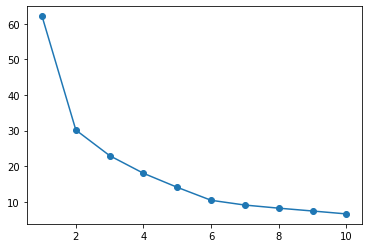

In [1885]:
plt.plot( range(1,11), distortions, marker= 'o' )

In [1890]:
km = KMeans( n_clusters=6, init='k-means++', n_init=10, max_iter = 500 , verbose = 0 )
label_km = km.fit_predict(distr)

In [1891]:
label_km

array([1, 5, 5, 5, 5, 5, 0, 5, 5, 5, 5, 5, 0, 1, 0, 5, 5, 5, 5, 5, 5, 5,
       1, 2, 0, 5, 5, 4, 4, 1, 0, 2, 2, 5, 5, 0, 0, 5, 5, 5, 0, 5, 5, 5,
       5, 5, 5, 5, 0, 1, 5, 1, 0, 5, 5, 0, 5, 5, 1, 0, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 5, 5, 5, 3, 3, 0, 0, 5,
       5, 5, 5, 2, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 0, 3,
       4, 3, 3, 3, 3, 1, 0, 5, 5, 5, 2, 0, 2, 0, 5, 5, 1, 0, 5, 5, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 2, 1, 5, 5, 5, 0, 0, 1, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 1, 0, 1, 1, 0, 1, 0, 5, 5, 5, 5, 1, 5, 5, 5,
       5, 0, 2, 0, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 0, 2, 0, 1, 0, 5, 5,
       2], dtype=int32)

 # Qualitative analysis

In [1355]:
# Find the 10 most common topic
topic_top = (-np.sum(distr, axis=0)).argsort()[:10]

In [1356]:
topic_top

array([ 0,  1,  3,  2,  8,  4, 20, 11, 14,  7])

In [1357]:
np.sum(distr, axis=0)[topic_top]

array([122.63858  ,  18.671772 ,  17.405247 ,  12.759808 ,   5.9355597,
         4.562676 ,   2.55607  ,   2.1271694,   2.0868   ,   1.715235 ],
      dtype=float32)

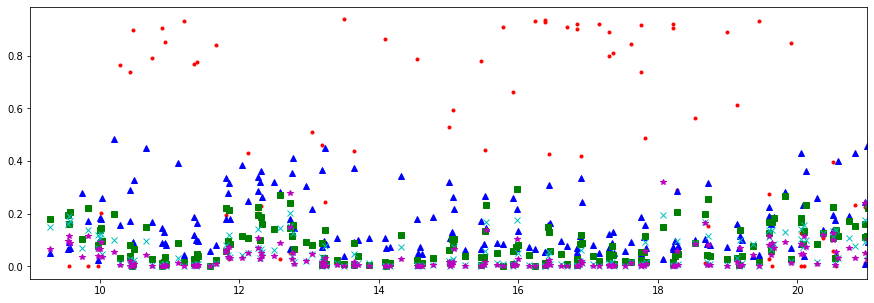

In [1731]:
fig, ax = plt.subplots( figsize=(15,5) )
topic_top = (-np.sum(distr0, axis=0)).argsort()[:10]

list_time = list( chain.from_iterable(time_interval) )[0:150]

lists = sorted(zip(*[ list_time , np.array(distr0).T[ topic_top[0] ]][0:150]  ))
new_x, new_y = list(zip(*lists))

ax.set_xlim([9, 21])
#plt.plot( new_x , new_y, 'r.-' )
plt.plot( list( chain.from_iterable(time_interval) )[100:] , np.array(distr0).T[ topic_top[0] ][100:], 'r.' )
plt.plot( list( chain.from_iterable(time_interval) ) , np.array(distr0).T[ topic_top[1] ], 'b^' )
plt.plot( list( chain.from_iterable(time_interval) ) , np.array(distr0).T[ topic_top[2] ], 'gs' )
plt.plot( list( chain.from_iterable(time_interval) ) , np.array(distr0).T[ topic_top[3] ], 'cx' )
plt.plot( list( chain.from_iterable(time_interval) ) , np.array(distr0).T[ topic_top[4] ], 'm*' )
#plt.plot( list( chain.from_iterable(time_interval) ) , np.array(distr).T[11], 'm*' )

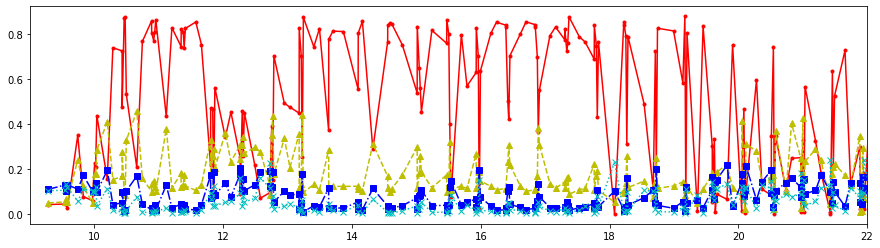

In [1809]:
fig, ax = plt.subplots( figsize=(15,4) )
topic_top = (-np.sum(distr0, axis=0)).argsort()[:10]

topic_top_reorder = []
list_time = list( chain.from_iterable(time_interval) )
time_reorder = []
for i in range(10):
    lists = sorted(zip(*[ list_time , np.array(distr0).T[ topic_top[i] ]]  ))
    time_reorder, topic_top_new = list(zip(*lists))
    topic_top_reorder.append( topic_top_new )

     
ax.set_xlim([9, 22])
#plt.plot( time_reorder , np.convolve( topic_top_reorder[0], np.ones((7,))/7, mode='same') , 'r.-' )
#plt.plot( time_reorder , np.convolve( topic_top_reorder[1], np.ones((7,))/7, mode='same') , 'y^--' )
#plt.plot( time_reorder , np.convolve( topic_top_reorder[2], np.ones((7,))/7, mode='same') , 'bs-.' )
#plt.plot( time_reorder , np.convolve( topic_top_reorder[3], np.ones((7,))/7, mode='same') , 'cx:' )
#plt.plot( time_reorder , np.convolve( topic_top_reorder[4], np.ones((7,))/7, mode='same') , 'm*-' )
plt.plot( time_reorder , topic_top_reorder[0], 'r.-' )
plt.plot( time_reorder , topic_top_reorder[1], 'y^--' )
plt.plot( time_reorder , topic_top_reorder[2], 'bs-.' )
plt.plot( time_reorder , topic_top_reorder[3], 'cx:' )
#plt.plot( time_reorder , topic_top_reorder[4], 'm*-' )
#plt.plot( list( chain.from_iterable(time_interval) ) , np.array(distr).T[11], 'm*' )

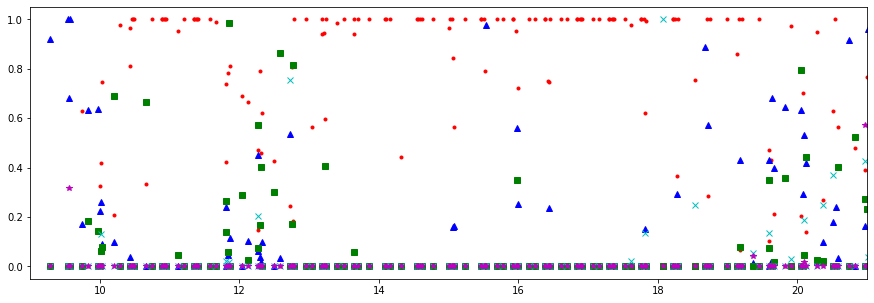

In [1715]:
fig, ax = plt.subplots( figsize=(15,5) )
topic_top = (-np.sum(distr, axis=0)).argsort()[:10]

list_time = list( chain.from_iterable(time_interval) )[0:150]

lists = sorted(zip(*[ list_time , np.array(distr).T[ topic_top[0] ]][0:150]  ))
new_x, new_y = list(zip(*lists))

ax.set_xlim([9, 21])
#plt.plot( new_x , new_y, 'r.-' )
plt.plot( list( chain.from_iterable(time_interval) ) , np.array(distr).T[ topic_top[0] ], 'r.' )
plt.plot( list( chain.from_iterable(time_interval) ) , np.array(distr).T[ topic_top[1] ], 'b^' )
plt.plot( list( chain.from_iterable(time_interval) ) , np.array(distr).T[ topic_top[2] ], 'gs' )
plt.plot( list( chain.from_iterable(time_interval) ) , np.array(distr).T[ topic_top[3] ], 'cx' )
plt.plot( list( chain.from_iterable(time_interval) ) , np.array(distr).T[ topic_top[4] ], 'm*' )
#plt.plot( list( chain.from_iterable(time_interval) ) , np.array(distr).T[11], 'm*' )

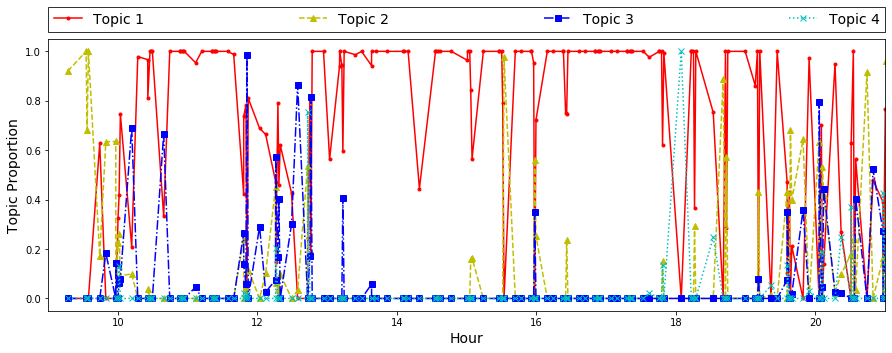

In [1881]:
fig, ax = plt.subplots( figsize=(15,5) )
topic_top = (-np.sum(distr, axis=0)).argsort()[:10]

topic_top_reorder = []
list_time = list( chain.from_iterable(time_interval) )
time_reorder = []
for i in range(10):
    lists = sorted(zip(*[ list_time , np.array(distr).T[ topic_top[i] ]]  ))
    time_reorder, topic_top_new = list(zip(*lists))
    topic_top_reorder.append( topic_top_new )

    

ax.set_xlim([9, 21])

ax.plot( time_reorder , topic_top_reorder[0], 'r.-' , label="Topic {}".format(1))
ax.plot( time_reorder , topic_top_reorder[1], 'y^--', label="Topic {}".format(2) )
ax.plot( time_reorder , topic_top_reorder[2], 'bs-.', label="Topic {}".format(3) )
ax.plot( time_reorder , topic_top_reorder[3], 'cx:', label="Topic {}".format(4) )
ax.set_xlabel('Hour', fontsize=14)
ax.set_ylabel('Topic Proportion', fontsize=14)

s = fig.subplotpars
bb=[s.left, s.top+0.02, s.right-s.left, 5 ]
leg = ax.legend( loc= 8,bbox_to_anchor=bb, mode="expand", borderaxespad=0, ncol= 4,
                bbox_transform=fig.transFigure, fancybox=False, edgecolor="k", prop={'size':14})
plt.show()

In [1426]:
time_interval[0]

[9.578333331402973,
 10.036666664736307,
 10.49499999806964,
 10.953333331402973,
 11.411666664736307,
 11.86999999806964,
 12.328333331402973,
 12.786666664736307,
 13.24499999806964,
 13.703333331402973,
 14.161666664736305,
 14.619999998069641,
 15.078333331402973,
 15.536666664736305,
 15.994999998069641,
 16.453333331402973,
 16.911666664736305,
 17.36999999806964,
 17.828333331402973,
 18.28666666473631,
 18.744999998069638,
 19.203333331402973,
 19.66166666473631,
 20.119999998069638,
 20.578333331402973,
 21.03666666473631,
 21.494999998069638,
 21.953333331402973,
 22.41166666473631]

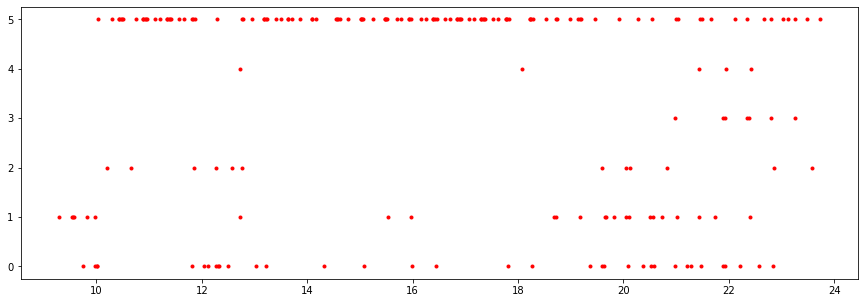

In [1892]:
fig, ax = plt.subplots( figsize=(15,5) )
plt.plot( list( chain.from_iterable(time_interval) ) , label_km, 'r.' )

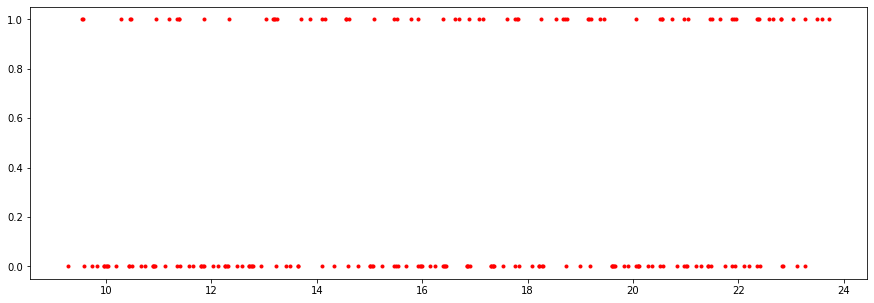

In [1912]:
fig, ax = plt.subplots( figsize=(15,5) )
plt.plot( list( chain.from_iterable(time_interval) ) , clustering_label, 'r.' )

In [948]:
routines_dominanting=[]
for i in  range(len(routines_all)):
    routine = mode( routines_all[i] )
    routines_dominanting.append( routine )

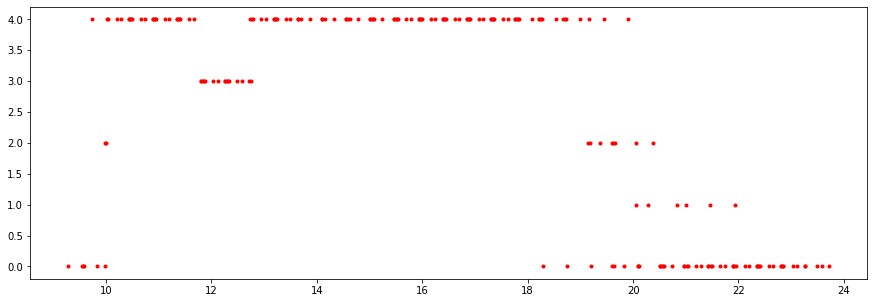

In [1495]:
fig, ax = plt.subplots( figsize=(15,5) )
plt.plot( list( chain.from_iterable(time_interval) ) , routines_dominanting, 'r.' )

# Testing: using the existing activitiy annotation

In [1894]:
count_act = CountVectorizer(min_df=3)
def activity_to_bow( activities , count ):
    act_list = []
    for act in activities:
        string=""
        for single_act in act:
            word = activities_label[single_act].replace(" ", "")
            string = string + word + " "
        act_list.append( string )

    bag = count.fit_transform( act_list )
    return bag, count

bag_act, count_act = activity_to_bow( activities_all , count_act )
id2token_act = {v: k for k, v in count_act.vocabulary_.items()}

bag_act_list = [ [] for _ in range( bag_act.shape[0] )]
for i, j in zip(*bag_act.nonzero()):
    bag_act_list[i].append( (j, bag_act[i,j] ) )

In [1924]:
model_hdp_act = HdpTransformer(id2word=id2token_act, kappa=1, alpha=0.1, gamma=0.1, K=15, T=35, tau=64)
model_hdp_act.fit( bag_act )
distr_act = model_hdp_act.transform( bag_act_list )
distr_act.shape

(199, 35)

In [ ]:
#model_hdp_list = []
##distr_ind = np.zeros( len(bag_list), 10 )
#n_hdp = 100
#distr_act_list = np.zeros( (n_hdp, len(bag_act_list), 5) )
#for i in range(n_hdp):
#    model_hdp_list.append( HdpTransformer(id2word=id2token,alpha=0.1, gamma=0.1, K=15, T=30, tau=64) )
#    model_hdp_list[-1].fit( bag_act )
#    distr0_act = model_hdp_list[-1].transform( bag_act_list ) 
#    topic_top_act = (-np.sum(distr0_act, axis=0)).argsort()[:5]
#    for i_doc in range( distr0_act.shape[0] ):
#        for i_topic in range(5):
##            print(i,i_doc,i_topic, distr0_act.shape)
#            distr_act_list[i][i_doc][i_topic] = distr0_act[i_doc][ topic_top_act[i_topic] ]

#distr0_act = np.mean(distr_act_list, axis=0)

In [1925]:
js_similarity_act = np.ones(shape=(distr_act.shape[0],distr_act.shape[0]))
for j in range(distr_act.shape[0]):
    for i in range( j+1 ):
#        js_similarity_act[i][j] = math.exp( - (jensenshannon( distr_act[i], distr_act[j] ) ) ) 
#        js_similarity_act[i][j] = math.exp( - (jensenshannon( distr_act[i], distr_act[j] ) )**2 ) 
        js_similarity_act[i][j] = np.sqrt( np.sum ( np.square( distr_act[i]- distr_act[j] ) ) )
        js_similarity_act[j][i] = js_similarity_act[i][j]
        
clustering_act = AffinityPropagation( affinity = 'precomputed', max_iter=1000 )
clustering_act_label = clustering_act.fit_predict( -js_similarity_act  )

In [1927]:
clustering_act_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0])

In [1928]:
topic_act_top = (-np.sum(distr_act, axis=0)).argsort()[:10]

In [1930]:
np.sum(distr, axis=0)[topic_top]

array([132.50682  ,  23.674374 ,  13.75415  ,   8.044653 ,   6.0442767,
         3.325031 ,   3.1003914,   1.6348279,   1.3992051,   1.0595305],
      dtype=float32)

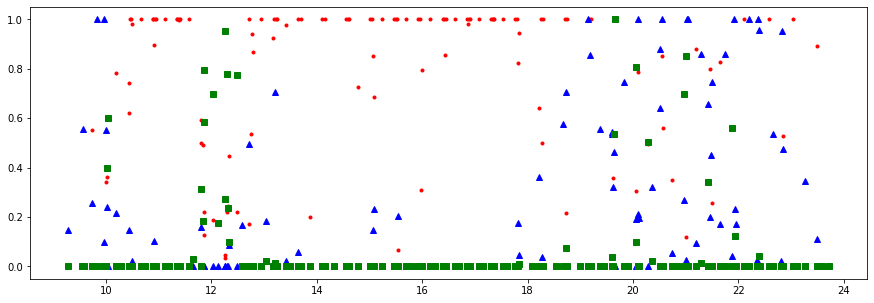

In [1655]:
topic_act_top = (-np.sum(distr_act, axis=0)).argsort()[:10]
fig, ax = plt.subplots( figsize=(15,5) )
plt.plot( list( chain.from_iterable(time_interval) )[0:150] , np.array(distr_act).T[ topic_act_top[0] ][0:150], 'r.' )
plt.plot( list( chain.from_iterable(time_interval) ) , np.array(distr_act).T[ topic_act_top[1] ], 'b^' )
plt.plot( list( chain.from_iterable(time_interval) ) , np.array(distr_act).T[ topic_act_top[2] ], 'gs' )
#plt.plot( list( chain.from_iterable(time_interval) ) , np.array(distr_act).T[3], 'gs' )

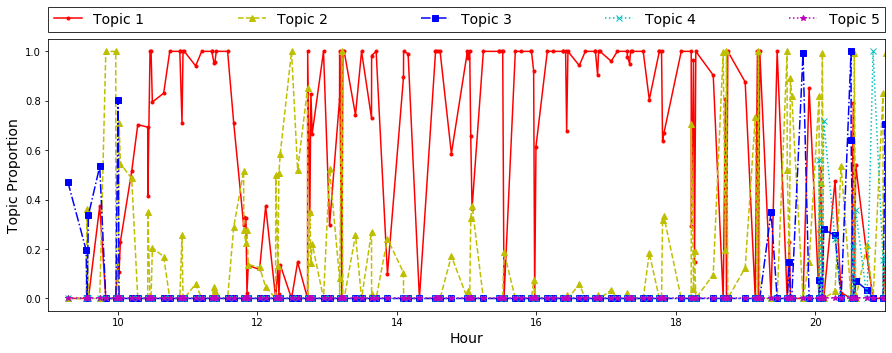

In [1931]:
fig, ax = plt.subplots( figsize=(15,5) )
topic_act_top = (-np.sum(distr, axis=0)).argsort()[:5]

topic_act_top_reorder = []
list_time = list( chain.from_iterable(time_interval) )
time_reorder = []
for i in range(5):
    lists = sorted(zip(*[ list_time , np.array(distr_act).T[ topic_top[i] ]]  ))
    time_reorder, topic_act_top_new = list(zip(*lists))
    topic_act_top_reorder.append( topic_act_top_new )

ax.set_xlim([9, 21])
plt.plot( time_reorder , topic_act_top_reorder[0], 'r.-' , label="Topic {}".format(1) )
#plt.plot( list( chain.from_iterable(time_interval) )[0:100] , np.array(distr).T[ topic_top[0] ][0:100], 'r.' )
plt.plot( time_reorder , topic_act_top_reorder[1], 'y^--', label="Topic {}".format(2) )
plt.plot( time_reorder , topic_act_top_reorder[2], 'bs-.', label="Topic {}".format(3) )
plt.plot( time_reorder , topic_act_top_reorder[3], 'cx:', label="Topic {}".format(4) )
plt.plot( time_reorder , topic_act_top_reorder[4], 'm*:', label="Topic {}".format(5) )

ax.set_xlabel('Hour', fontsize=14)
ax.set_ylabel('Topic Proportion', fontsize=14)

s = fig.subplotpars
bb=[s.left, s.top+0.02, s.right-s.left, 5 ]
leg = ax.legend( loc= 8,bbox_to_anchor=bb, mode="expand", borderaxespad=0, ncol= 5,
                bbox_transform=fig.transFigure, fancybox=False, edgecolor="k", prop={'size':14})
plt.show()